**Ejercicio 1**: Datos no Estructurados, clasificación de documentos en formato imagen de Davivienda.

**Por**: *David Doncel Ballén*, creado en agosto 7 de 2022.

**Code Repository**: https://github.com/DaDo82/Machine-Learning/tree/main/Ej1_clasificacion_img_doc

# Ejercicio 1 - Clasificación de documentos con o sin contenido en formato imagen.

El objetivo de este ejercicio es clasificar hojas de documentos con o sin contenido que se encuentran en formato imagen implementando una red neuronal artificial multicapa desde cero.
Es importante reconocer el aporte de Juan Ignacio Bagnato el autor del blog Aprende Machine Learning (https://www.aprendemachinelearning.com/), que gracias a sus ejemplos se logran adaptar y desaroolar el código que encontraran en este note book.

# Contenido

- [Cargue de las Imágenes](#Cargue-de-las-imágenes)
  - [Lecturas de las imágenes](#Lecturas-de-las-imágenes)
- [Selección de las muestras de entrenamiento y validación](#Selección-de-las-muestras-de-entrenamiento-y-validación)
- [Definición de los parámetros de la RED](#Definición-de-los-parámetros-de-la-RED)
- [Análisis de Resultados](#Análisis-de-Resultados)
  - [Probando la clasificación del modelo con los datos de Testeo](#Probando-la-clasificación-del-modelo-con-los-datos-de-Testeo)


<br>
<br>

# Cargue de las Imágenes

In [1]:
#Librerias básicas para el análisis y visualización de datos
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

#Librerias Machine Learning y Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical

#Activación de TensorFlow con Tarjeta Gráfica Nvidia Geforce GTX 1650 TI
import tensorflow as tf
from tensorflow.keras import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from keras.models import Sequential

## Lecturas de las imágenes

In [2]:
dirname = os.path.join(os.getcwd(), 'Datasets')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imágenes en cada directorio", dircount)
print('Suma Total de imágenes en subdirs:',sum(dircount))

leyendo imagenes de  D:\Data_Science\Pruebas\Davivienda\Ejercicio_1_Imagenes\Notebook\Datasets\
D:\Data_Science\Pruebas\Davivienda\Ejercicio_1_Imagenes\Notebook\Datasets\Blanco 1
D:\Data_Science\Pruebas\Davivienda\Ejercicio_1_Imagenes\Notebook\Datasets\Documentos 147
Directorios leidos: 2
Imágenes en cada directorio [148, 99]
Suma Total de imágenes en subdirs: 247


In [3]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

tipo_documento=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    tipo_documento.append(name[len(name)-1])
    indice=indice+1
    
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #conviertiendo a matriz

# Creación de labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)


Cantidad etiquetas creadas:  247
0 Blanco
1 Documentos
Total number of outputs :  2
Output classes :  [0 1]


# Selección de las muestras de entrenamiento y validación
En este paso la categoria se convierte a codificación, es decir, documento [1, 0], en blanco [1, 0]. Esto ayuda a mejorar el rendimiento de la RED y la ontención de la respuesta. Asimismo se define un conjunto de 80% de datos para entrenamiento y 20% de testeo.

In [4]:
# Mezclar todo y crear los grupos de entrenamiento y testeo
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# cambiando las categorias por la codificación de 0 y 1
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Categoria Original:', train_Y[0])
print('Despues de aplicar la codificación:', train_Y_one_hot[0])

train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Training data shape :  (197, 400, 250, 3) (197,)
Testing data shape :  (50, 400, 250, 3) (50,)
Categoria Original: 0
Despues de aplicar la codificación: [1. 0.]
(157, 400, 250, 3) (40, 400, 250, 3) (157, 2) (40, 2)


# Definición de los parámetros de la RED
Se opta por seleccionar un set de procesamiento de 16 imágenes y un filtro de 5x5 para la convolución. Aumentar estos parámetros conlleva a disminuir la precisión de la RED NEURONAL. Y con 50 epocas hay tendencia de incremento de la precisión aunque con apariciones de máximos locales.

In [5]:
INIT_LR = 1e-3
epochs = 50
batch_size = 16

Imgclass_model = Sequential()
Imgclass_model.add(Conv2D(16, kernel_size=(5, 5),activation='linear',padding='same',input_shape=(400,250,3)))
Imgclass_model.add(LeakyReLU(alpha=0.1))
Imgclass_model.add(MaxPooling2D((2, 2),padding='same'))
Imgclass_model.add(Dropout(0.5))

Imgclass_model.add(Flatten())
Imgclass_model.add(Dense(16, activation='linear'))
Imgclass_model.add(LeakyReLU(alpha=0.1))
Imgclass_model.add(Dropout(0.5)) 
Imgclass_model.add(Dense(nClasses, activation='softmax'))

Imgclass_model.summary()

Imgclass_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 250, 16)      1216      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 400, 250, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 125, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 200, 125, 16)      0         
                                                                 
 flatten (Flatten)           (None, 400000)            0         
                                                                 
 dense (Dense)               (None, 16)                6400016   
                                                        

In [6]:
Imgclass_train = Imgclass_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

# Se guarda la red
Imgclass_model.save("docs_modelClass.h5py")

Epoch 1/50
10/10 [==============================] - 3s 82ms/step - loss: 2.3570 - accuracy: 0.4968 - val_loss: 0.7207 - val_accuracy: 0.6250
Epoch 2/50
10/10 [==============================] - 0s 37ms/step - loss: 0.8953 - accuracy: 0.5924 - val_loss: 0.6526 - val_accuracy: 0.6250
Epoch 3/50
10/10 [==============================] - 0s 37ms/step - loss: 0.7749 - accuracy: 0.5414 - val_loss: 0.6423 - val_accuracy: 0.6250
Epoch 4/50
10/10 [==============================] - 0s 37ms/step - loss: 0.7221 - accuracy: 0.6242 - val_loss: 0.6281 - val_accuracy: 0.6250
Epoch 5/50
10/10 [==============================] - 0s 37ms/step - loss: 0.6693 - accuracy: 0.6433 - val_loss: 0.6143 - val_accuracy: 0.7250
Epoch 6/50
10/10 [==============================] - 0s 37ms/step - loss: 0.6915 - accuracy: 0.5860 - val_loss: 0.6081 - val_accuracy: 0.6250
Epoch 7/50
10/10 [==============================] - 0s 37ms/step - loss: 0.6426 - accuracy: 0.6369 - val_loss: 0.6332 - val_accuracy: 0.6250
Epoch 8/50
10

INFO:tensorflow:Assets written to: docs_modelClass.h5py\assets


INFO:tensorflow:Assets written to: docs_modelClass.h5py\assets


# Análisis de Resultados
Se alcanza una precisión del 98 % que se contrastará con al matriz de confusión.No obstante entre la época 20 y 25 se aprecia que la RED alcanza el máximo global.

In [7]:
test_eval = Imgclass_model.evaluate(test_X, test_Y_one_hot, verbose=1)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

2/2 [==============================] - 1s 154ms/step - loss: 0.0982 - accuracy: 0.9800
Test loss: 0.09816303104162216
Test accuracy: 0.9800000190734863


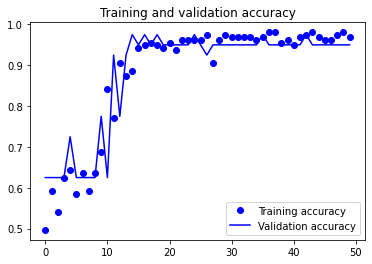

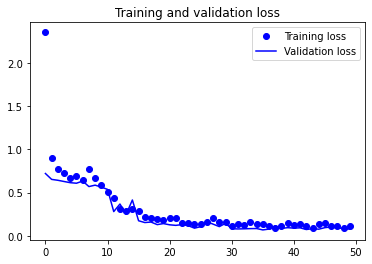

In [8]:
accuracy = Imgclass_train.history['accuracy']
val_accuracy = Imgclass_train.history['val_accuracy']
loss = Imgclass_train.history['loss']
val_loss = Imgclass_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [9]:
predicted_classes2 = Imgclass_model.predict(test_X)

2/2 [==============================] - 0s 25ms/step


In [10]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [11]:
predicted_classes.shape, test_Y.shape

((50,), (50,))

## Probando la clasificación del modelo con los datos de Testeo
Con el test de 50 datos, 49 fueron clasificados de manera correcta y uno de manera incorrecta.

Found 49 correct labels


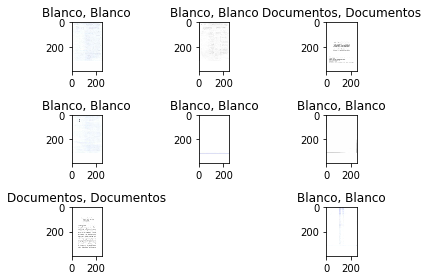

In [12]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(400,250,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(tipo_documento[predicted_classes[correct]],
                                                    tipo_documento[test_Y[correct]]))

    plt.tight_layout()

Found 1 incorrect labels


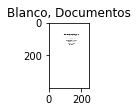

In [13]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(400,250,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(tipo_documento[predicted_classes[incorrect]],
                                                    tipo_documento[test_Y[incorrect]]))
    plt.tight_layout()

In [14]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98        29
     Class 1       1.00      0.95      0.98        21

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



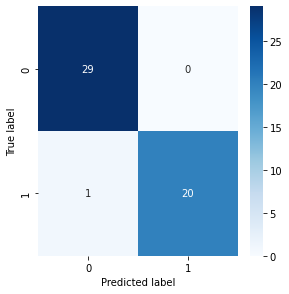

In [15]:
mat_tf=tf.math.confusion_matrix(
    test_Y,
    predicted_classes,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.float32,
    name=None
)

con_mat_df = pd.DataFrame(mat_tf,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(4, 4))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [16]:
#Cálculo de la matriz de confusión nromalizada
con_mat = tf.math.confusion_matrix(labels=test_Y, predictions=predicted_classes).numpy()

In [17]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

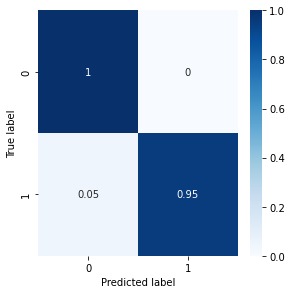

In [18]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Conclusión
El modelo obtenido muestra un buen desempeño en la clasificación de documentos con contenido y sin contenido en formato imagen, logrando una precisión del 98%. No obstante, en varios intentos y modelos que se probaron previamente se encontró que el modelo se le dificulta clasificar correctamente los documentos con poco contendo y lo clasifica como documento en blanco. Esta parte se mejoró ajustando las épocas, el número de filtros (16), el tamaño del kernel (5x5) y la definición de 16 neuronas tradicionales para una salida de 2 neuronas con activiación "Softmax". En este sentido, queda planteado seguir probando más modelos cambiando la función de activación y comparar sus resultados.
De otra, parte la activación de la tarjeta gráfica con la libreria tensorFlow optimiza el rendimiento en equipos personales, que sin este recurso otro equipo hubiera demandado mayor tiempo de ejecución lo que implicaría ajustar reducir los parámetros de la RED lo cual afecta su rendimiento. Sin embargo, una solución a esta situación es usar Google Colab.